# MyFitnessPal: Guide to data extraction and analysis

<img src="https://i.imgur.com/4g4i8g8.png" height=500>

A picture of the MyFitnessPal Mobile Application

Do you know that DIET stands for Did I Eat That? <br> <br>
Jokes aside, in this notebook we will be doing just that. We will connect to the Cronometer API to analyze the participants nutritional and exercise habits.

MyFitnessPal is regarded as a personal diary for logging nutrition and exercise. It lets you track your meals and workouts and provides you with required nutrition figures to attain your desired body measurements.

MyFitnessPal follows a freemium model offering a digital service accessible through its mobile applications (iOS and Android). Users also have an option to upgrade and unlock more advanced features like Custom Calorie Goals, In-depth meal Analysis, Workout Routines, etc for a monthly fee of $9.99.

We've been using the MyFitnessPlan application for the past few weeks and we will show you how to extract its data, visualize your meals and compute correlations between multiple metrics of the data. Wearipedia can easily extract from MyFitnessPal servers for our use case.


For this notebook we will be focusing on metrics of the participant's activities like calories, micronutrients, macronutrients, workouts, etc.

We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
Calorie Intake |  Per Food Item 
Carbohydrates |  Per Food Item 
Fat |  Per Food Item
Protein |  Per Food Item
Sodium |  Per Food Item
Sugar |  Per Food Item 
Vitamin A |  Per Food Item 
Vitamin C |  Per Food Item 
Iron |  Per Food Item 
Calcium |  Per Food Item 
Fibre |  Per Food Item 
Calories Burned |  Per Activity 
Sets/Reps |  Per Exercise
Weights |  Per Exercise
Weight |  Depending upon User's inputs
Height |  Depending upon User's inputs
Neck |  Depending upon User's inputs
Waist |  Depending upon User's inputs
Hips |  Depending upon User's inputs

** Calories and nutrients are subsets of goals, dailySummary, lunch, breakfast and dinner. 

In this guide, we sequentially cover the following **five** topics to extract data from Cronometer servers:

1. **Setup**<br>
2. **Authentication and Authorization**<br>
   - Requires cookies from your browser to login.<br>
3. **Data Extraction**<br>
  - We get data via wearipedia in a couple lines of code<br>
4. **Data Exporting**
    - We export all of this data to file formats compatible by R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced Visualization**
    - 7.1 Visualizing participant's Weekly Calorie Intake! <br>
    - 7.2 Visualizing participant's Weekly Workout Repetitions! <br>
    - 7.3 Visualizing Participant's Weekly Carbohydrate Intake! <br>
8. **Statistical Data Analysis** <br>
  - 8.1  Checking Protein Intake! <br>
9. **Outlier Detection and Data Cleaning** <br>
  - 9.1 Highlighting Outliers!

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own cookies on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## Participant Setup

Dear Participant,

Once you download the MyFitnessPal app, please set it up by following these resources:
- Written guide: https://blog.myfitnesspal.com/essential-guide-to-food-logging
- Video guide: https://www.youtube.com/watch?v=fu9RKqlmD1Q&ab_channel=MyFitnessPalApp

Make sure that your phone is logged to the MyFitnessPal app using the MyFitnessPal login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a MyFitnessPal account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.
5. Install the `wearipedia` Python package to easily extract data from this device via the Cronometer API.
6. Make sure that your MyFitnessPal account is logged into your browser inorder to correctly extract the cookies.


In [72]:
!pip install wearipedia
!pip install openpyxl
!pip uninstall -y seaborn
!pip install seaborn==0.11.1

Found existing installation: seaborn 0.11.1
Uninstalling seaborn-0.11.1:
  Successfully uninstalled seaborn-0.11.1
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [1]:
import wearipedia
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import http.cookiejar as cookiejar
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date


# 2. Authentication and Authorization

To obtain access to data, authorization is required. Unfortunately, for MyFitnessPal, just using email and password is not sufficient to authorize data extraction from their API. We will have to extract the cookies stored on your local machine inorder to authenticate agaist the MyFitnessPal API. 

Note: If you are running this on your local machine (where MyFitnessPal is logged in), you most likely would not have to seperately extract cookies to do this. However to get MyFitnessPal working for Google colab we will have to go through this step.

Step 1: Run the following python script on your local machine. 


```
import browsercookie
import json
import http.cookiejar as cookiejar

# Extracts all the user cookies from the browser and saves them in a file
def download_cookies():

    cookies = browsercookie.load()
    cookiefiles = []

    # Add the cookies to the CookieJar object
    for cookie in cookies:
        cookie_dict = cookie.__dict__
        cookie_dict['rest'] = cookie_dict['_rest']
        del cookie_dict['_rest']
        cookiefiles.append(cookie_dict)

    # Save the cookies to the JSON file
    with open('cookies.json', 'w') as f:
        json.dump(cookiefiles, f)

# Calling the function
download_cookies()
```

This should create a file called <b><i>cookies.json</b></i> within the same directory.<br>
<img src='https://i.imgur.com/tNTNFKv.png'>


Step 2: Upload the exctracted json file in the cell below.

In [10]:
from google.colab import files
cookies = files.upload()

# 3. Data Extraction

Data can be extracted via [wearipedia](https://github.com/Stanford-Health/wearipedia/), our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox.

In [11]:
jar2 = cookiejar.CookieJar()
with open(list(cookies.keys())[0], 'r') as f:
        data = json.load(f)
for cookie in data:
  jar2.set_cookie(cookiejar.Cookie(**cookie))

In [12]:
#@title Enter start and end dates (in the format yyyy-mm-dd)

#set start and end dates - this will give you all the data from 2000-01-01 (January 1st, 2000) to 2100-02-03 (February 3rd, 2100), for example
start_date='2022-03-01' #@param {type:"string"}
end_date='2022-06-17' #@param {type:"string"}
synthetic = True #@param {type:"boolean"}

In [13]:
device = wearipedia.get_device("myfitnesspal/myfitnesspal")

if not synthetic:
    # Cookie jar will be passed as a parameter. If nothing is passed, our 
    # authenticate function will try to use locally stored cookies.
    device.authenticate({'cookies':jar2})

params = {"start_date": start_date, "end_date": end_date}


After authentication, we can finally load our data. 

In [14]:
goals = device.get_data("goals", params=params)
daily_summary = device.get_data('daily_summary',params=params)
exercises_cardio = device.get_data('exercises_cardio',params=params)
exercises_strength = device.get_data('exercises_strength',params=params)
lunch = device.get_data('lunch',params=params)
breakfast = device.get_data('breakfast',params=params)
dinner = device.get_data('dinner',params=params)
snacks = device.get_data('snacks',params=params)


# 4. Data Exporting

In this section, we export all of this data to formats compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). Specifically, we will first export to JSON, which can be read by R and Matlab. Then, we will export to CSV, which can be consumed by Excel, Google Sheets, and every other popular programming language.

## Exporting to JSON (R, Matlab, etc.)

Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [15]:
# This function will cleanup the timestamp objects and convert them to text
# as timestamp objects are not JSON Serializable
def datacleanup(data):
  res = []
  for d in data:
    if 'date' in d:
      d['date'] = str(d['date'])
    if type(d)==list:
      if 'day' in d[0]:
        d[0]['day'] = str(d[0]['day'])
      if 'date' in d[0]:
        d[0]['date'] = str(d[0]['date'])
    res.append(d)
  return res

In [16]:


json.dump(datacleanup(goals), open("goals.json", "w"))
json.dump(datacleanup(daily_summary), open("daily_summary.json", "w"))
json.dump(datacleanup(exercises_cardio), open("exercises_cardio.json", "w"))
json.dump(datacleanup(exercises_strength), open("exercises_strength.json", "w"))
json.dump(datacleanup(lunch), open("lunch.json", "w"))
json.dump(datacleanup(breakfast), open("breakfast.json", "w"))
json.dump(datacleanup(dinner), open("dinner.json", "w"))
json.dump(datacleanup(snacks), open("snacks.json", "w"))

complete = {
    "goals": goals,
    "daily_summary": daily_summary,
    "exercises_cardio": exercises_cardio,
    "exercises_strength": exercises_strength,
    "lunch": lunch,
    "breakfast": breakfast,
    "dinner": dinner,
    "snacks": snacks,
}

json.dump(complete, open("complete.json", "w"))

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

Exporting to CSV/XLSX requires a bit more processing, since they enforce a pretty restrictive schema.

We will thus export steps, heart rates, and breath rates all as separate files.

In [17]:
dailySummary_df = pd.DataFrame.from_dict(daily_summary)
dailySummary_df.to_csv('dailySummary.csv')
dailySummary_df.to_excel('dailySummary.xlsx')

goals_df = pd.DataFrame.from_dict(goals)

goals_df.to_csv('goals.csv', index=False)
goals_df.to_excel('goals.xlsx', index=False)

exercises_cardio_df = pd.DataFrame()

for e in exercises_cardio:
    for exercise in e[1:]:
        data_dict = {
            'day':e[0]['day'],
            'name':exercise['name'],
            'nutrition_information':[exercise['nutrition_information']]
        }
        
        data_dict_df = pd.DataFrame.from_dict(data_dict)
        exercises_cardio_df = pd.concat([exercises_cardio_df,data_dict_df], ignore_index=True)


exercises_cardio_df.to_csv('exercises_cardio.csv', index=False)
exercises_cardio_df.to_excel('exercises_cardio.xlsx', index=False)

exercises_strength_df = pd.DataFrame()

for e in exercises_strength:
    for exercise in e[1:]:
        data_dict = {
            'day':e[0]['date'],
            'name':exercise['name'],
            'nutrition_information':[exercise['nutrition_information']]
        }
        data_dict_df = pd.DataFrame.from_dict(data_dict)
        exercises_strength_df = pd.concat([exercises_strength_df,data_dict_df], ignore_index=True)

exercises_strength_df.to_csv('exercises_strength.csv', index=False)
exercises_strength_df.to_excel('exercises_strength.xlsx', index=False)

lunch_df = pd.DataFrame()

lunch_df = lunch_df.assign(day=[e[0]['day'] for e in 
lunch])
lunch_df = lunch_df.assign(name=[e[1]['name'] for e in 
lunch])
lunch_df = lunch_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in lunch])
lunch_df = lunch_df.assign(totals=
[l[1]['totals'] for l in lunch])

lunch_df.to_csv('lunch.csv', index=False)
lunch_df.to_excel('lunch.xlsx', index=False)

dinner_df = pd.DataFrame()

dinner_df = dinner_df.assign(day=[e[0]['day'] for e in 
dinner])
dinner_df = dinner_df.assign(name=[l[1]['name'] for l in 
dinner])
dinner_df = dinner_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in dinner])
dinner_df = dinner_df.assign(totals=
[l[1]['totals'] for l in dinner])

dinner_df.to_csv('dinner.csv', index=False)
dinner_df.to_excel('dinner.xlsx', index=False)

breakfast_df = pd.DataFrame()

breakfast_df = breakfast_df.assign(day=[e[0]['day'] for e in 
breakfast])
breakfast_df = breakfast_df.assign(name=[l[1]['name'] for l in 
breakfast])
breakfast_df = breakfast_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in breakfast])
breakfast_df = breakfast_df.assign(totals=
[l[1]['totals'] for l in breakfast])

breakfast_df.to_csv('breakfast.csv', index=False)
breakfast_df.to_excel('breakfast.xlsx', index=False)


snacks_df = pd.DataFrame()

snacks_df = snacks_df.assign(day=[e[0]['day'] for e in 
snacks])
snacks_df = snacks_df.assign(name=[l[1]['name'] for l in 
snacks])
snacks_df = snacks_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in snacks])
snacks_df = snacks_df.assign(totals=
[l[1]['totals'] for l in snacks])

snacks_df.to_csv('snacks.csv', index=False)
snacks_df.to_excel('snacks.xlsx', index=False)

Again, feel free to look at the output files and download them.

# 5. Adherence

The device simulator already automatically randomly deletes small chunks of the day. In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level).

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [18]:
#@title Non-adherence simulation
block_level = "day" #@param ["day", "week"]
adherence_percent = 0.89 #@param {type:"slider", min:0, max:1, step:0.01}

In [19]:
if block_level == "day":
    block_length = 1
elif block_level == "week":
    block_length = 7



# This function will randomly remove datapoints from the 
# data we have recieved from Cronometer based on the
# adherence_percent

def AdherenceSimulator(data):

  num_blocks = len(data) // block_length
  num_blocks_to_keep = int(adherence_percent * num_blocks)
  idxes = np.random.choice(np.arange(num_blocks), replace=False, 
  size=num_blocks_to_keep)

  adhered_data = []

  for i in range(len(data)):
      if i in idxes:
          start = i * block_length
          end = (i + 1) * block_length
          for j in range(i,i+1):
            adhered_data.append(data[j])
  
  return adhered_data


# Adding adherence for daily summary

dailySummary = AdherenceSimulator(daily_summary)

# Adding adherence for strength exercises

exercises_strength = AdherenceSimulator(exercises_strength)

# Adding adherence for cardio exercises

exercises_cardio = AdherenceSimulator(exercises_cardio)

# Adding adherence for goals

goals = AdherenceSimulator(goals)

# Adding adherence for lunch

lunch = AdherenceSimulator(lunch)

# Adding adherence for dinner

dinner = AdherenceSimulator(dinner)

# Adding adherence for breakfast

breakfast = AdherenceSimulator(breakfast)

# Adding adherence for snacks

snacks = AdherenceSimulator(snacks)

And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled at every day.

In [20]:
dailySummary_df = pd.DataFrame.from_dict(daily_summary)

goals_df = pd.DataFrame.from_dict(goals)

exercises_cardio_df = pd.DataFrame()
exercises_cardio_df = exercises_cardio_df.assign(day=[e[0]['day'] for e in 
exercises_cardio])
exercises_cardio_df = exercises_cardio_df.assign(name=[e[1]['name'] for e in 
exercises_cardio])
exercises_cardio_df = exercises_cardio_df.assign(nutrition_information=
[e[1]['nutrition_information'] for e in exercises_cardio])

exercises_strength_df = pd.DataFrame()
exercises_strength_df = exercises_strength_df.assign(day=[e[0]['date'] for e in 
exercises_strength])
exercises_strength_df = exercises_strength_df.assign(name=[e[1]['name'] for e in 
exercises_strength])
exercises_strength_df = exercises_strength_df.assign(nutrition_information=
[e[1]['nutrition_information'] for e in exercises_strength])

lunch_df = pd.DataFrame()
lunch_df = lunch_df.assign(day=[e[0]['day'] for e in 
lunch])
lunch_df = lunch_df.assign(name=[e[1]['name'] for e in 
lunch])
lunch_df = lunch_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in lunch])
lunch_df = lunch_df.assign(totals=
[l[1]['totals'] for l in lunch])

dinner_df = pd.DataFrame()
dinner_df = dinner_df.assign(day=[e[0]['day'] for e in 
dinner])
dinner_df = dinner_df.assign(name=[l[1]['name'] for l in 
dinner])
dinner_df = dinner_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in dinner])
dinner_df = dinner_df.assign(totals=
[l[1]['totals'] for l in dinner])

breakfast_df = pd.DataFrame()
breakfast_df = breakfast_df.assign(day=[e[0]['day'] for e in 
breakfast])
breakfast_df = breakfast_df.assign(name=[l[1]['name'] for l in 
breakfast])
breakfast_df = breakfast_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in breakfast])
breakfast_df = breakfast_df.assign(totals=
[l[1]['totals'] for l in breakfast])

snacks_df = pd.DataFrame()
snacks_df = snacks_df.assign(day=[e[0]['day'] for e in 
snacks])
snacks_df = snacks_df.assign(name=[l[1]['name'] for l in 
snacks])
snacks_df = snacks_df.assign(nutrition_information=
[l[1]['nutrition_information'] for l in snacks])
snacks_df = snacks_df.assign(totals=
[l[1]['totals'] for l in snacks])

We can plot this out, and we get adherence at one-day frequency throughout the entirety of the data collection period. For this chart we will plot Calories consumed during breakfast over the time period from the breakfast dataframe.

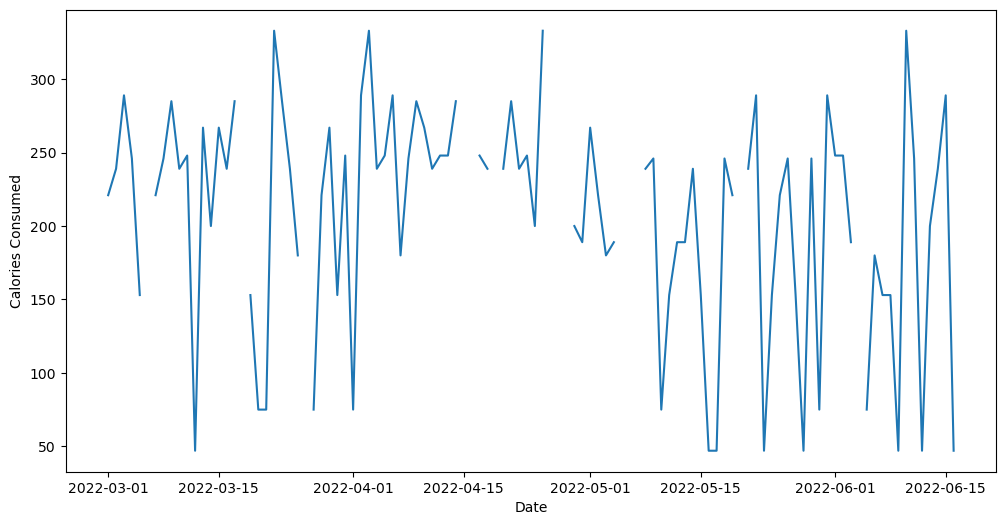

In [21]:
dates = pd.date_range(start_date,end_date)

calories = []

for d in dates:
  res = lunch_df[lunch_df.day == datetime.strftime(d,
  '%Y-%m-%d')+' 00:00:00']['nutrition_information']
  if len(res) == 0:
    calories.append(None)
  else:
    calories.append(res.iloc[0]['calories'])

plt.figure(figsize=(12, 6))
plt.plot(dates, calories)
plt.ylabel('Calories Consumed')
plt.xlabel('Date')
plt.show()

Using this, let's calculate the distribution of days where then calorie consumption was surprisingly low

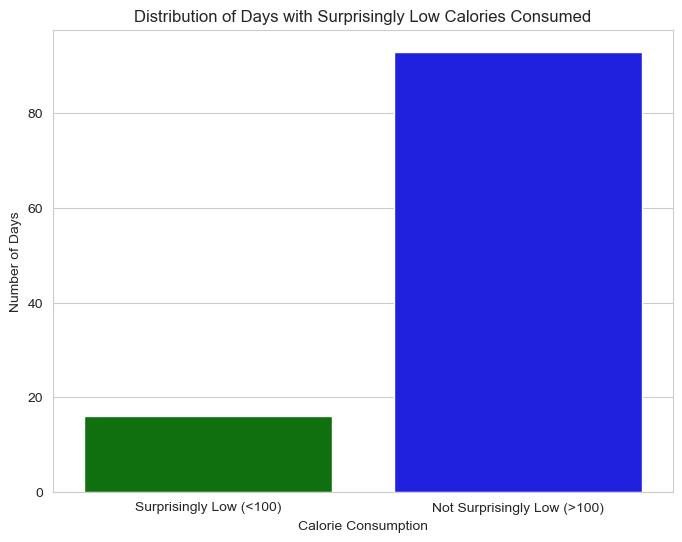

In [22]:
# Define the threshold for "surprisingly low" calories
surprisingly_low_threshold = 100.0

# Count the days with surprisingly low calories
surprisingly_low_days = sum(1 for c in calories if c is not None and c < surprisingly_low_threshold)

# Count the days with calories above the threshold
non_surprisingly_low_days = len(calories) - surprisingly_low_days

# Data for the bar plot
categories = ['Surprisingly Low (<100)', 'Not Surprisingly Low (>100)']
values = [surprisingly_low_days, non_surprisingly_low_days]

# Set the Seaborn style
sns.set_style("whitegrid")

# Create the bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette=['green', 'blue'])
plt.title('Distribution of Days with Surprisingly Low Calories Consumed')
plt.ylabel('Number of Days')
plt.xlabel('Calorie Consumption')
plt.show()

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

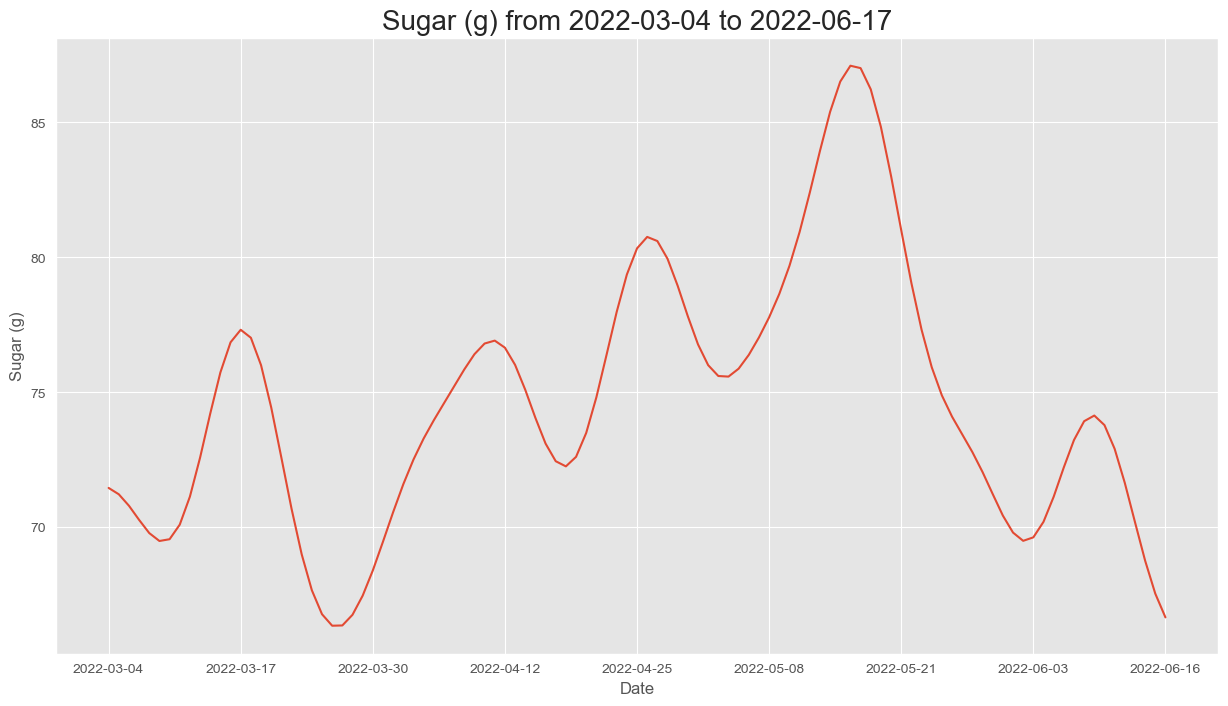

In [23]:
#@title Basic Plot
feature = "sugar" #@param ['calories', 'carbohydrates', 'fat', 'protein', 'sodium', 'sugar']
start_date = "2022-03-04" #@param {type:"date"}
time_interval = "full time" #@param ["one week", "full time"]
smoothness = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
smooth_plot = True #@param {type:"boolean"}

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

start_date = datetime.strptime(start_date, '%Y-%m-%d')

if time_interval == "one week":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date and d <= start_date + timedelta(days=7)]
    end_date = start_date + timedelta(days=7)
elif time_interval == "full time":
    day_idxes = [i for i,d in enumerate(dates) if d >= start_date]
    end_date = dates[-1]

if feature == "calories":
    calories = dailySummary_df.get(['calories','date'])
    concat_cals = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          calorie = calories[calories['date']==day]
          if len(calorie) != 0:
              concat_cals += [(day[:10],calorie.iloc[0].calories)]
          else:
              concat_cals += [(day[:10],None)]
    ts = [x[0] for x in concat_cals]

    day_arr = [x[1] for x in concat_cals]

    sigma = 200 * smoothness

    title_fillin = "Calorie"

  
if feature == "carbohydrates":
    carbohydrates = dailySummary_df.get(['carbohydrates','date'])
    concat_carbs = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          carb = carbohydrates[carbohydrates['date']==day]
          if len(carb) != 0:
              concat_carbs += [(day[:10],carb.iloc[0].carbohydrates)]
          else:
              concat_carbs += [(day[:10],None)]
    ts = [x[0] for x in concat_carbs]

    day_arr = [x[1] for x in concat_carbs]

    sigma = 200 * smoothness

    title_fillin = "Carbohydrates (g)"
    
if feature == "fat":
    fats_df = dailySummary_df.get(['fat','date'])
    concat_fats = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          fats = fats_df[fats_df['date']==day]
          if len(fats) != 0:
              concat_fats += [(day[:10],fats.iloc[0].fat)]
          else:
              concat_fats += [(day[:10],None)]
    ts = [x[0] for x in concat_fats]

    day_arr = [x[1] for x in concat_fats]

    sigma = 200 * smoothness

    title_fillin = "Fat (g)"
    
if feature == "protein":
    protein_df = dailySummary_df.get(['protein','date'])
    concat_proteins = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          protein = protein_df[protein_df['date']==day]
          if len(protein) != 0:
              concat_proteins += [(day[:10],protein.iloc[0].protein)]
          else:
              concat_proteins += [(day[:10],None)]
    ts = [x[0] for x in concat_proteins]

    day_arr = [x[1] for x in concat_proteins]

    sigma = 200 * smoothness

    title_fillin = "Protein (g)"

if feature == "sugar":
    sugar_df = dailySummary_df.get(['sugar','date'])
    concat_sugar = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          sugar_item = sugar_df[sugar_df['date']==day]
          if len(sugar_item) != 0:
              concat_sugar += [(day[:10],sugar_item.iloc[0].sugar)]
          else:
              concat_sugar += [(day[:10],None)]
    ts = [x[0] for x in concat_sugar]

    day_arr = [x[1] for x in concat_sugar]

    sigma = 200 * smoothness

    title_fillin = "Sugar (g)"

if feature == "sodium":
    sodium_df = dailySummary_df.get(['sodium','date'])
    concat_sodium = []
    for i,d in enumerate(dates):
        day = d.strftime('%Y-%m-%d')+' 00:00:00'
        if i in day_idxes:
          sodium = sodium_df[sodium_df['date']==day]
          if len(sodium) != 0:
              concat_sodium += [(day[:10],sodium.iloc[0].sodium)]
          else:
              concat_sodium += [(day[:10],None)]
    ts = [x[0] for x in concat_sodium]

    day_arr = [x[1] for x in concat_sodium]

    sigma = 200 * smoothness

    title_fillin = "Sodium (g)"

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 8))

    if smooth_plot:
        def to_numpy(day_arr):
            arr_nonone = [x for x in day_arr if x is not None]
            mean_val = int(np.mean(arr_nonone))
            for i,x in enumerate(day_arr):
                if x is None:
                    day_arr[i] = mean_val

            return np.array(day_arr)

        none_idxes = [i for i,x in enumerate(day_arr) if x is None]
        day_arr = to_numpy(day_arr)
        from scipy.ndimage import gaussian_filter
        day_arr = list(gaussian_filter(day_arr, sigma=sigma))
        for i, x in enumerate(day_arr):
            if i in none_idxes:
                day_arr[i] = None

    plt.plot(ts, day_arr)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    plt.title(f"{title_fillin} from {start_date_str} to {end_date_str}",
              fontsize=20)
    plt.xlabel("Date")
    plt.xticks(ts[::int(len(ts)/8)])
    plt.ylabel(title_fillin)

This plot allows you to quickly scan your data at many different time scales (week and full) and for different kinds of measurements (calories, carbohydrates, fat, protein, sodium, and sugar), which enables easy and fast data exploration.

Furthermore, the smoothness parameter makes it easy to look for patterns in long-term trends.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that at times features hardcore matplotlib hacking with the benefit of aesthetic quality.

## 4.1 Visualizing participant's Weekly Calorie intake!

Whenever our participant is curious and logs into MyFitnessPal App to check their overall Calorie intake summary, the MyFitnessPal app would present their data in the form of a bar chart. It should look something similar to this:

<img src="https://i.imgur.com/NS9X8DR.jpg" height=400>

*Above is a plot from the mobile app itself!*

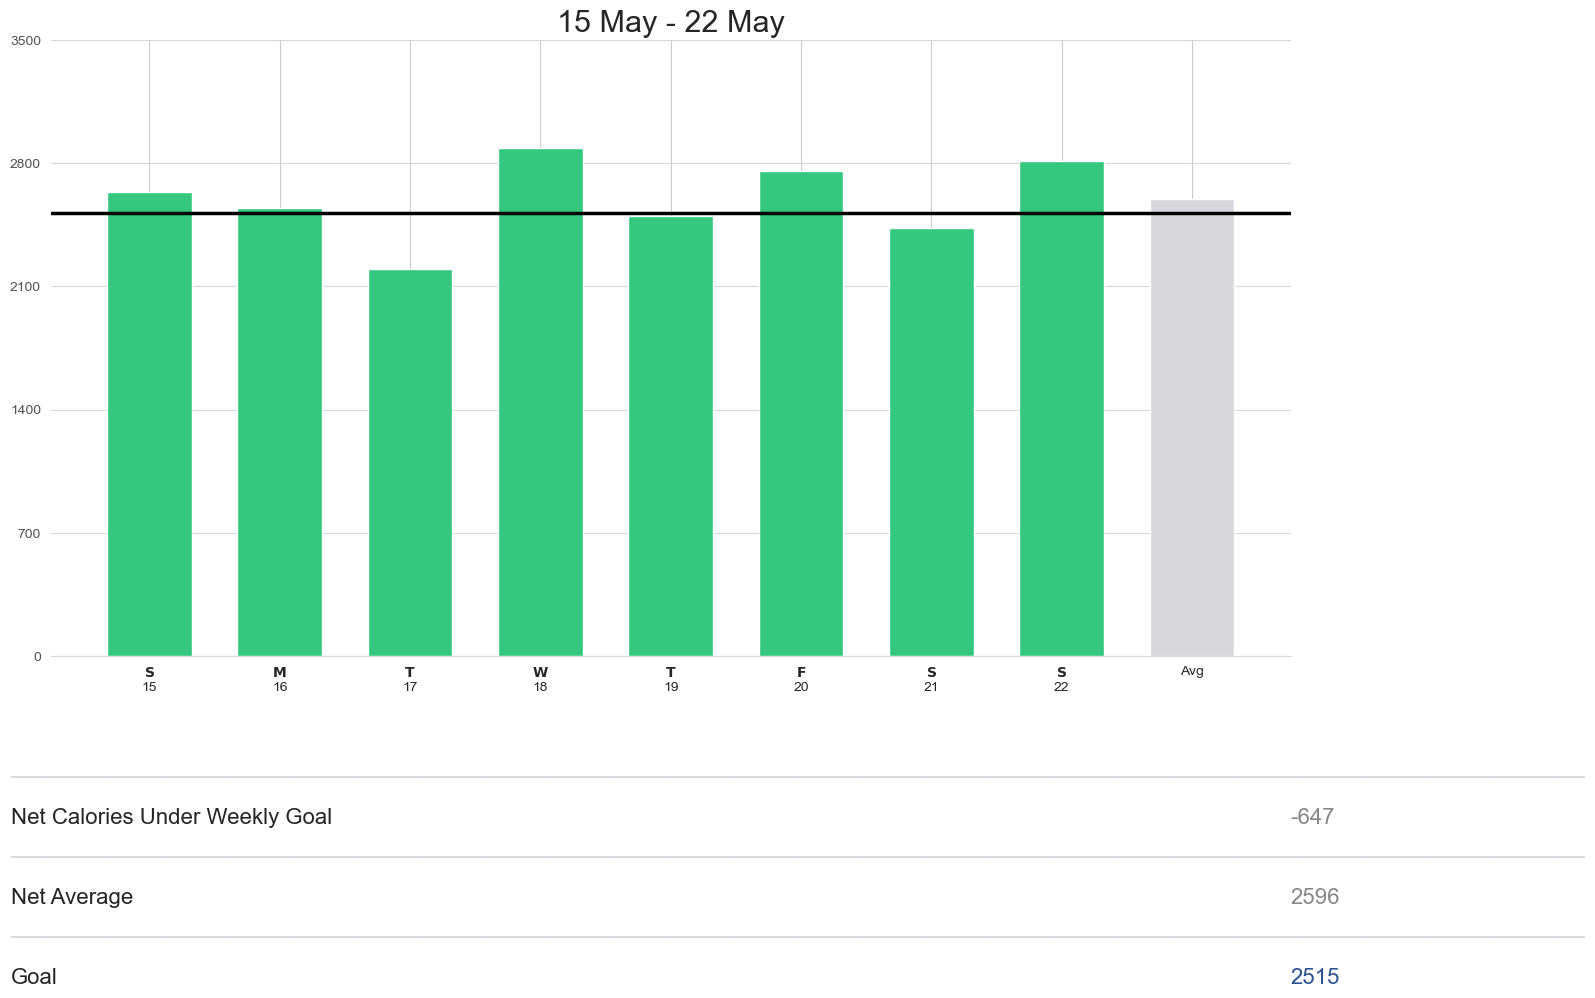

In [24]:
#@title Set date range for the chart above

start = "2022-05-15" #@param {type:"date"}
end = "2022-05-22" #@param {type:"date"}

# Starting date of our chart
start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                  int(start.split('-')[2]))

# Ending date of our chart
end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                int(end.split('-')[2]))

# A list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date,freq='d'))

# Creating a dictionary of days with calories
calories = {}

# Creating a list to store all threshold values (Daily Goals)
threshold = []

# Saving a list of human readable dates for our reference
Dates = []

# Appending data for all days between x and y into the calories dictionary
for i in dates:
    
    threshold_data = goals_df[goals_df['date'] == str(i)]
    
    if len(threshold_data) > 0:
        threshold.append(threshold_data.iloc[0].calories)
    else:
        threshold.append(0)
  
    Dates.append(str(i))

    # xtick values are formatted for matplot lib to recognize the bold and non-bold portions
    
    calorie_data = dailySummary_df[dailySummary_df['date'] == str(i)]
    if len(calorie_data)>0:
        calories["$\\bf{"+i.strftime("%A")[0]+"}$\n"+
           str(i)[8:10]] = calorie_data.iloc[0].calories
# Creating DataFrame for our Calorie values and calculating the required metrics
calorie_df = pd.DataFrame(calories.items(), columns=['xtick', 'Calorie Value'])
calorie_df = calorie_df.assign(Date = Dates)
calorie_df = calorie_df.assign(threshold = [float(t) for t in threshold])
calorie_df = calorie_df.assign(calorie_under_goal =  
                calorie_df.get('threshold') - calorie_df.get('Calorie Value'))
calorie_df = calorie_df.set_index('Date')
# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()


# Setting the title for the plot
date_range = (str(start_date.day)+' '+str(start_date.strftime("%B"))+
              ' - '+str(end_date.day)+' '+str(end_date.strftime("%B")))
plt.title(date_range,fontsize=22)

# Plotting the weekly values for calorie intake
plt.bar(calorie_df.get('xtick'),calorie_df.get('Calorie Value'), 
        width=0.65, color ="#33C77F")

# Plotting the Average Calorie intake
plt.bar(["Avg"],np.mean(list(calorie_df.get('Calorie Value'))),
        width=0.65, color="#D8D7DC")



# Adding veritcal grids
plt.grid(axis="y", color="#D8D7DC")
ax.set_axisbelow(True)

# Setting custom yticks of gap 700 calories between each
plt.yticks([0,700,1400,2100,2800, 3500])

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Plotting the threshold line
plt.axhline(y=np.mean(threshold),linewidth=2.5, color='k')

# Changing color of bottom axis and yticks
ax.spines['bottom'].set_color('#D8D7DC')
ax.tick_params(axis='y', colors='#525252')

# Printing the Weekly Statistics
plt.figtext(0.1,-0.05,"─────"*20,fontsize=16,color="#D8D7DC")
plt.figtext(0.1,-0.1,"Net Calories Under Weekly Goal", fontsize=16)
plt.figtext(0.1,-0.15,"─────"*20,fontsize=16,color="#D8D7DC")
plt.figtext(0.9,-0.1,str(int(np.sum(calorie_df.get('calorie_under_goal')))),
            fontsize=16,color="#88878B")
plt.figtext(0.1,-0.2,"Net Average", fontsize=16)
plt.figtext(0.9,-0.2,str(int(np.mean(calorie_df.get('Calorie Value')))),
            fontsize=16,color="#88878B")
plt.figtext(0.1,-0.25,"─────"*20,fontsize=16,color="#D8D7DC")
plt.figtext(0.1,-0.3,"Goal", fontsize=16)
plt.figtext(0.9,-0.3,str(int(np.mean(calorie_df.get('threshold')))),
            fontsize=16,color="#2C5391")

plt.show()

*^ Above is a plot we created ourselves!*

## 4.2 Visualizing participant's Weekly Workout Reps!


As the API allows us to access a participants fitness data. Next, let's try to find what exercises the participant does the most in a week, this would help them get a clear idea of what muscles are being trained more frequently with the most amount of repetitions. <br><br>
Below is a sample chart which we would be modeling our chart on.

<img src="https://i.imgur.com/jQEkl5M.png" width=900>

*Above is a plot from the mobile app itself!*

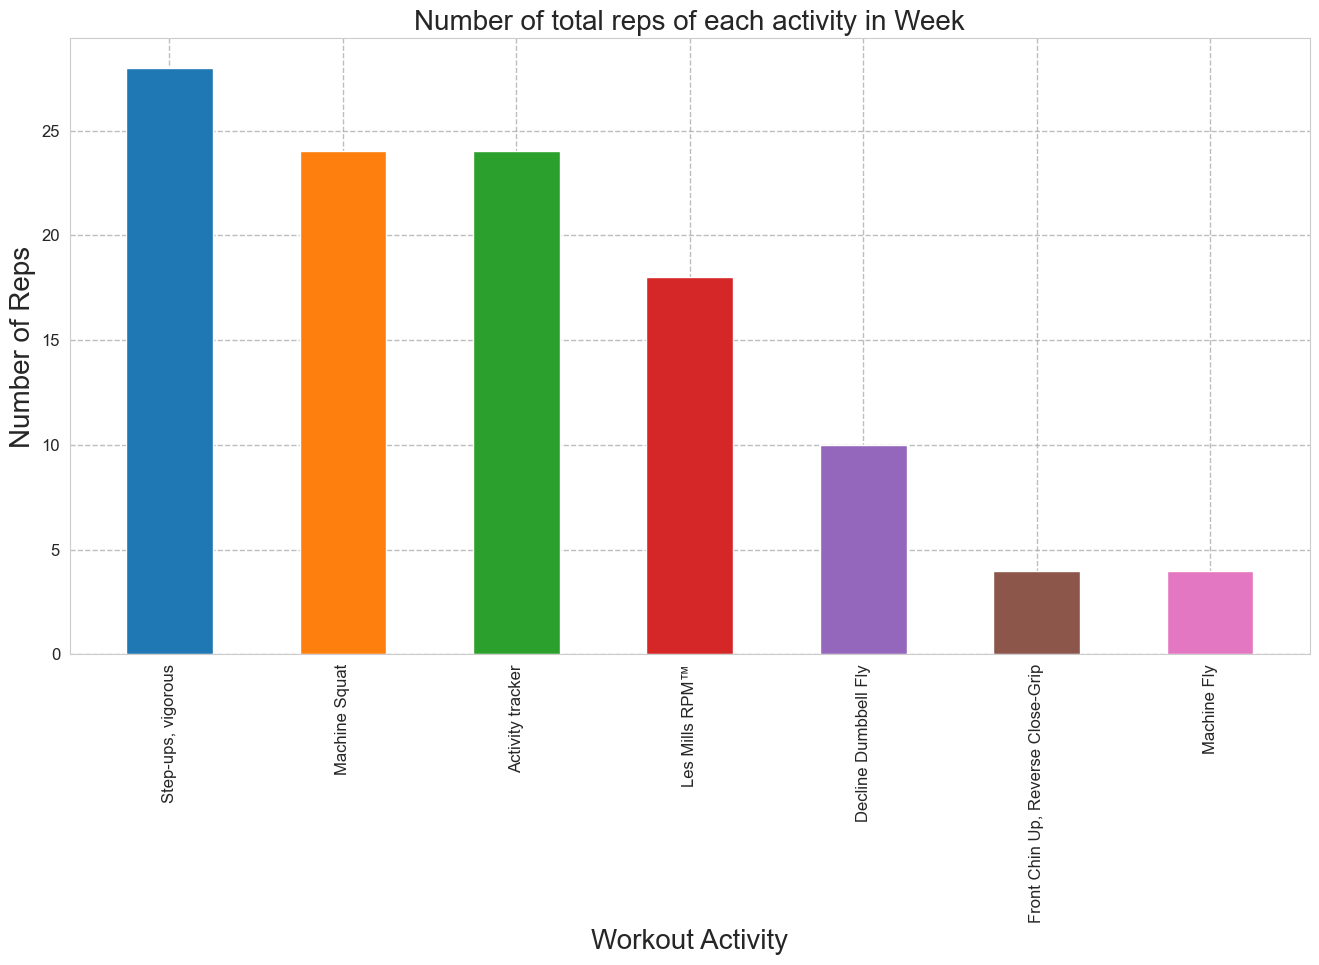

In [25]:
#@title Set date range for the chart below

start = "2022-05-12" #@param {type:"date"}
end = "2022-05-19" #@param {type:"date"}

# Starting date of our chart
start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                  int(start.split('-')[2]))

# Ending date of our chart
end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                int(end.split('-')[2]))

# A list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date,freq='d'))

# Dictionary to save all the exercises
exercises = {}

# Going through all the days in the week to count all exercises
for d in dates:
    day = exercises_strength_df[exercises_strength_df['day']==str(d)]
    for i in range(len(day)):
        exercise = day.iloc[i]
        if exercise['name'] not in exercises:
            exercises[exercise['name']] = (exercise['nutrition_information']['sets'] *
                                  exercise['nutrition_information']['reps/set'])
        else:
            exercises[exercise['name']] =+(exercise['nutrition_information']['sets'] *
                                  exercise['nutrition_information']['reps/set'])
      
# Sorting Dictionary in Descending order and storing it in a list
exercises = sorted(exercises.items(), key=lambda x: x[1], reverse=True)

# Creating a DataFrame for our exercises and counts
exercises_df = pd.DataFrame()
exercises_df = exercises_df.assign(Name=[e[0] for e in exercises])
exercises_df = exercises_df.assign(Count=[e[1] for e in exercises])

# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()


# Creating the grids
plt.grid(color="#a1a1a1", linestyle='--', linewidth=1, alpha = 0.7)

# Setting colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plotting a Bar chart
plt.bar(exercises_df.get('Name'),exercises_df.get('Count'), 
        width=0.5, color=colors)

# Rotating xticks
plt.xticks(rotation = 90)

# Incresing font size for y ticks
ax.tick_params(axis='both', labelsize=12)

# Setting x & y labels
plt.ylabel("Number of Reps", size=20)
plt.xlabel("Workout Activity", size=20)

# Setting plot title
plt.title('Number of total reps of each activity in Week', size=20)

plt.show()

*^ Above is a plot we created ourselves!*


## 4.3 Participant's Weekly Carbohydrate Intake!

Similar to 4.1, whenever our participant is curious and logs into MyFitnessPal App to check their overall Carbohydrates intake summary, the MyFitnessPal app would present their data in the form of a bar chart. It should look something similar to this:

<img src="https://i.imgur.com/eqQAtFt.jpg" width='500px'>

*Above is a plot from the mobile app itself!*

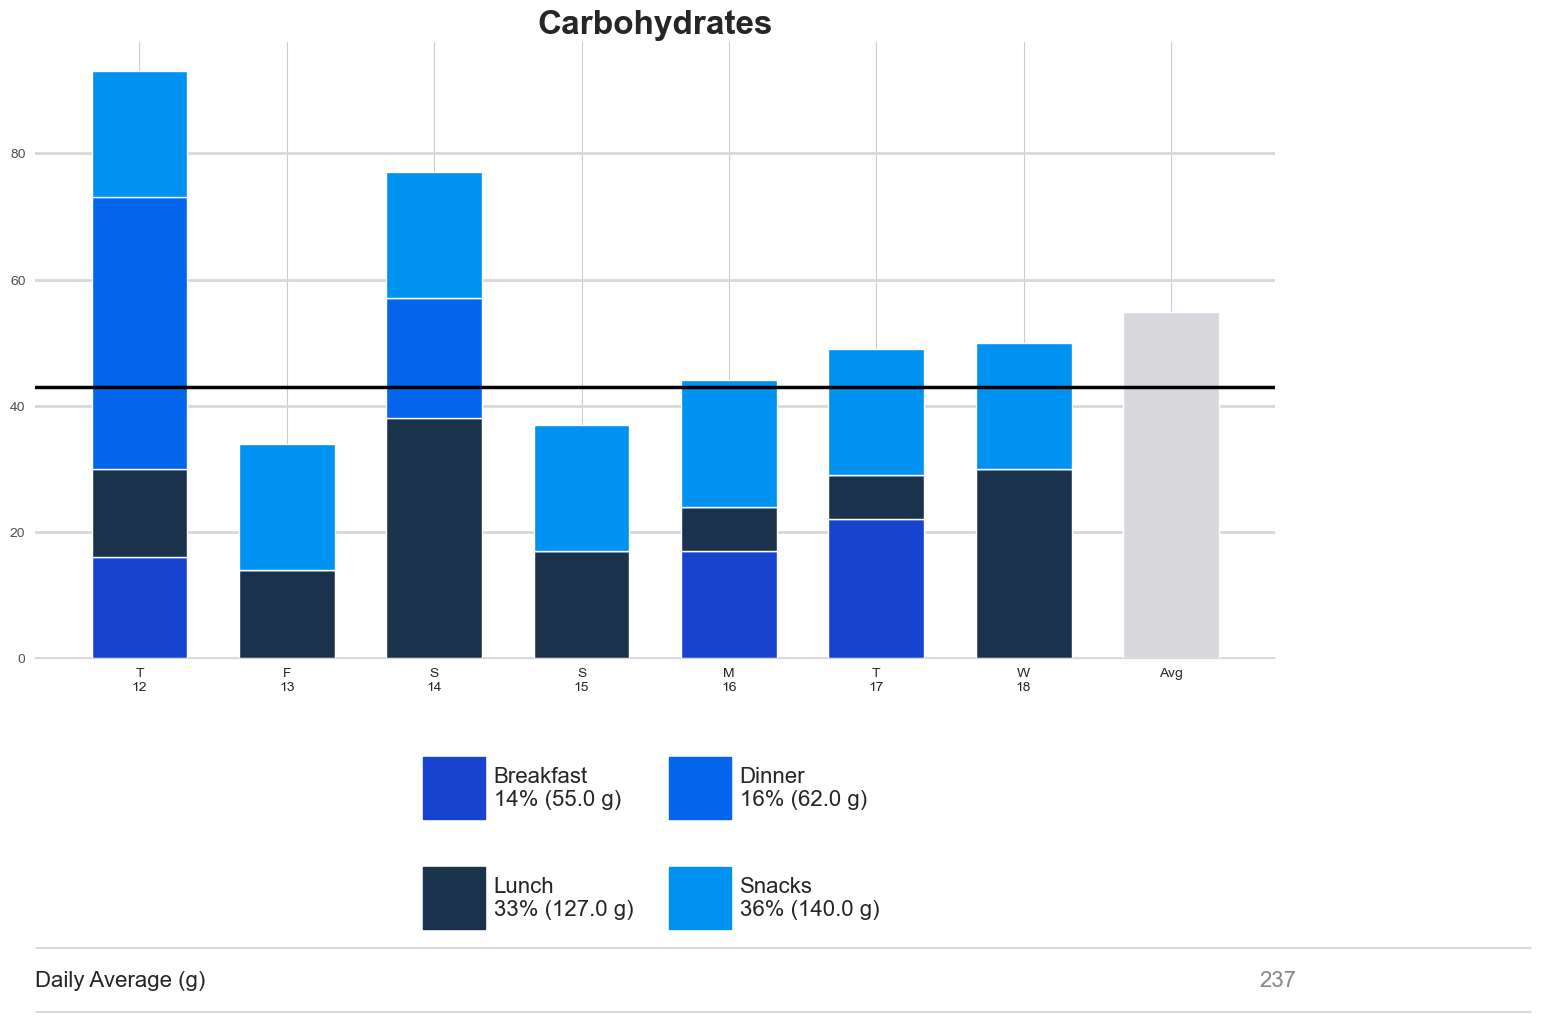

In [26]:
#@title Set date range for the chart below

start = "2022-05-12" #@param {type:"date"}
end = "2022-05-18" #@param {type:"date"}

from matplotlib import lines as mlines

# Starting date of our chart
start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                  int(start.split('-')[2]))

# Ending date of our chart
end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                int(end.split('-')[2]))

# A list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date,freq='d'))

# Creating a dictionary of days with overall carbohydrates for the day
carbs = {}

# Storing a list of dates
date_list = []

# Creating a list to store all carbohydrate threshold values (Daily Goals)
carb_threshold = []

# Creating a dictionary of days with breakfast carbohydrates for the day
brcarbs = {}

# Creating a dictionary of days with lunch carbohydrates for the day
lunchcarbs = {}

# Creating a dictionary of days with dinner carbohydrates for the day
dinnercarbs = {}

# Creating a dictionary of days with snack carbohydrates for the day
sncarbs = {}

# Appending data for all days between x and y into the required dictionaries
for d in dates:
    goal = goals_df[goals_df['date']==str(d)]
    if len(goal)>0:
        carb_threshold.append(goal.iloc[0].carbohydrates)
    else:
        carb_threshold.append(0)
        
    date_list.append(str(d))
    
    carbs[d.strftime("%A")[0]+"\n"+str(d)[:10].split('-')[-1]] = (0 if
    len(dailySummary_df[dailySummary_df['date']==str(d)]) == 0  else dailySummary_df[dailySummary_df['date']==str(d)].iloc[0].carbohydrates)
    
    brcarbs[d.strftime("%A")[0]+"\n"+str(d)[:10].split('-')[-1]] = (0 if
    len(breakfast_df[breakfast_df['day']==str(d)]) == 0  else breakfast_df[breakfast_df['day']==str(d)].iloc[0]['nutrition_information']['carbohydrates'])
    
    lunchcarbs[d.strftime("%A")[0]+"\n"+str(d)[:10].split('-')[-1]] = (0 if
    len(lunch_df[lunch_df['day']==str(d)]) == 0  else lunch_df[lunch_df['day']==str(d)].iloc[0]['nutrition_information']['carbohydrates'])
    
    dinnercarbs[d.strftime("%A")[0]+"\n"+str(d)[:10].split('-')[-1]] =  (0 if
    len(dinner_df[dinner_df['day']==str(d)]) == 0  else dinner_df[dinner_df['day']==str(d)].iloc[0]['nutrition_information']['carbohydrates'])
    
    sncarbs[d.strftime("%A")[0]+"\n"+str(d)[:10].split('-')[-1]] =  (0 if
    len(snacks_df[snacks_df['day']==str(d)]) == 0  else snacks_df[snacks_df['day']==str(d)].iloc[0]['nutrition_information']['carbohydrates'])
    
    # Calculating the metadata for our legend
breakfast_total = sum(brcarbs.values())
lunch_total = sum(lunchcarbs.values())
dinner_total = sum(dinnercarbs.values())
snacks_total = sum(sncarbs.values())
carbs_total = list(brcarbs.values())+ list(lunchcarbs.values())+ list(dinnercarbs.values()) + list(sncarbs.values())
total_carbs = breakfast_total+lunch_total+dinner_total+snacks_total


# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8))

ax = plt1.gca()

# Plotting the weekly values for carbohydrates consumed in breakfast
plt.bar(brcarbs.keys(),brcarbs.values(), width=0.65, color ="#1843CE")

# Plotting the weekly values for carbohydrates consumed in lunch
plt.bar(lunchcarbs.keys(),lunchcarbs.values(), bottom=list(brcarbs.values()), 
        width=0.65, color ="#1B324D")

# Plotting the weekly values for carbohydrates consumed in dinner
plt.bar(dinnercarbs.keys(),dinnercarbs.values(), bottom = [l+b for b, l in
      zip(brcarbs.values(), lunchcarbs.values())], width=0.65, color="#0366ED")

# Plotting the weekly values for carbohydrates consumed in snacks
plt.bar(sncarbs.keys(),sncarbs.values(), bottom = [l+b+d for b, l, d in
        zip(brcarbs.values(), lunchcarbs.values(),dinnercarbs.values())],
        width=0.65, color="#0092F0")

# Plotting the Average Calorie intake
plt.bar(["Avg"],total_carbs/len(carbs),width=0.65, color="#D8D7DC")



# Adding veritcal grids
plt.grid(axis="y", color="#D8D7DC",lw=2)
ax.set_axisbelow(True)

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Plotting the threshold line
plt.axhline(y=np.max(carbs_total),linewidth=2.5, color='k')

#Plotting the legend
rect1 = mlines.Line2D([], [], marker="s", markersize=30, linewidth=0,
                      color="#1843CE")
rect2 = mlines.Line2D([], [], marker="s", markersize=30, linewidth=0,
                      color="#1B324D")
rect3 = mlines.Line2D([], [], marker="s", markersize=30, linewidth=0,
                      color="#0366ED")
rect4 = mlines.Line2D([], [], marker="s", markersize=30, linewidth=0,
                      color="#0092F0")
ax.legend((rect1, rect2,rect3,rect4), ("Breakfast"+"\n"+
        str(int(breakfast_total / total_carbs *100))+
        "% ("+str(breakfast_total)+" g)", "Lunch"+"\n"+
        str(int(lunch_total / total_carbs *100))+"% ("+str(lunch_total)+" g)",
         "Dinner"+"\n"+str(int(dinner_total / total_carbs *100))+
         "% ("+str(dinner_total)+" g)", "Snacks"+"\n"+
         str(int(snacks_total / total_carbs *100))+"% ("+str(snacks_total)+" g)"
         ),bbox_to_anchor=(0.5,-0.3), loc="center", frameon=False, ncol=2,
          markerscale=1.5, fontsize=16 , labelspacing=3)

# Changing color of bottom axis and yticks
ax.spines['bottom'].set_color('#D8D7DC')
ax.tick_params(axis='y', colors='#525252')

# Displaying the Chart Summary
plt.figtext(0.125,-0.26,"─────"*19,fontsize=16,color="#D8D7DC")
plt.figtext(0.125,-0.3,"Daily Average (g)", fontsize=16)
plt.figtext(0.89,-0.3,str(int(np.mean(list(carbs.values())))),
            fontsize=16,color="#88878B")
plt.figtext(0.125,-0.34,"─────"*19,fontsize=16,color="#D8D7DC")

# Adding chart title
plt.title('Carbohydrates',fontsize=24,fontweight='bold')


# Showing the plot
plt.show()

    

*^ Above is a plot we created ourselves!*


# 8. Statistical Data Analysis

According to the United States Department of Agriculture (USDA), the recommended daily intake of protein for adult men is 0.8 grams per kilogram of body weight. This is based on a daily energy intake of 2,000 calories.

### Testing Protein Consumption

For this experiment, let's assume that we are trying to be make sure that the user's consumption of protein should average out to the required protein requirement (population mean).

In [27]:
#@title Set weight (in pounds) for the analysis below
weight = 155 #@param {type:"integer"}
# 1 pound = 0.453592 kg
protein_required = weight*0.8*0.453592

In this section, we will conduct a one-sample t-test to test our protein consumption. To test this hypothesis, we will utilize our data on the user's protein consumption and compare it to the required protein level for their weight. Then, we would then use a t-test to determine whether the difference between the two is statistically significant. If the p-value of the t-test is less than the predetermined alpha level (usually 0.05), we can reject the null hypothesis and conclude that the user's protein consumption is indeed lower than the required protein level. If the p-value is greater than the alpha level, we cannot reject the null hypothesis and must conclude that there is not enough evidence to support the alternative hypothesis. <br>


<b>Null hypothesis (H0):</b> The user's protein consumption is equal to or greater than the required protein level.

<b>Alternative hypothesis (H1):</b> The user's protein consumption is lower than the required protein level. <br>

The one-sample t-test is a statistical test used to determine whether a sample mean is significantly different from a known population mean. The t-test formula for a one-sample t-test is as follows:

t = (x̄ - μ) / (s / √n)

where:


<ul>
<li>x̄ is the sample mean</li>
<li>μ is the population mean</li>
<li>s is the sample standard deviation</li>
<li>n is the sample size</li>
</ul> <br>
The t-test statistic is then used to determine the p-value, which is the probability of obtaining a result as extreme as the one observed, given that the null hypothesis is true. If the p-value is less than the predetermined alpha level (usually 0.05), you can reject the null hypothesis and conclude that there is a statistically significant difference between the sample mean and the population mean. If the p-value is greater than the alpha level, you cannot reject the null hypothesis and must conclude that there is not enough evidence to support the alternative hypothesis.



In [28]:
test_result = stats.ttest_1samp(dailySummary_df.get('protein'), popmean=protein_required,alternative='less')

print('p-value:',test_result.pvalue)

p-value: 1.0


In this case, as the p-value of the t-test is 1.0, this means that the observed difference between the user's protein consumption and the required protein level is extremely unlikely to have occurred by chance. Based on this result, you cannot reject the null hypothesis and must conclude that there is not enough evidence to support the alternative hypothesis, which is that the user's protein consumption is lower than the required protein level.


# 9. Outlier Detection and Data Cleaning

However, even though our P value seems to provide enough statistical significance that our user's protein consumption is not below the USDA's recommendation. However, there might be outliers that are not following this correlation. In this section of our analysis, we will find if there are outliers like that and if they exist, we should find those exact days where protein consumption was lower than recommended.

Before finding the individual outlier values, it would be interesting to see the summary of our Protein intake. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from MyFitnessPal.

In [29]:
dailySummary_df.get('protein').describe()

count    108.000000
mean      97.537037
std       32.874700
min       26.200000
25%       80.975000
50%       98.600000
75%      119.075000
max      187.600000
Name: protein, dtype: float64

Plotting this data would also make it easier to infer the distribution of our protein intake

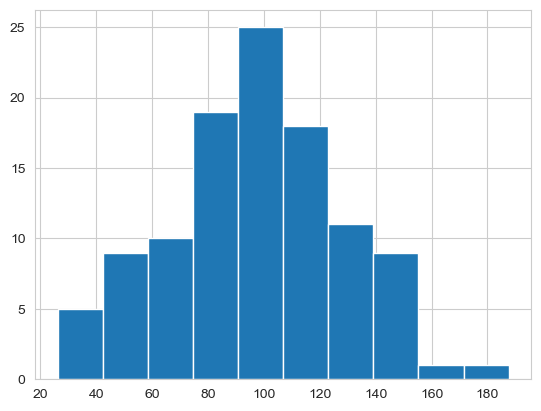

In [30]:
plt.hist(dailySummary_df.get('protein'))
plt.show()

To identify the outliers in a t-test, you will need to calculate the t-test statistic and compare it to the critical value. Outliers are observations that are significantly different from the rest of the data and can impact the results of the t-test.

We will find the 95% confidence interval from our mean using our t-test and use it to find the outlying numbers



<img src='https://i.imgur.com/EeJtTL4.png' height=100>

In [31]:
from scipy.stats import t, sem

# Finding ta,df
t_a_df = t.ppf(q=.05,df=len(dailySummary_df)-1)

# using ta,df to find the lower bound
lower_bound = protein_required + (t_a_df*dailySummary_df.get('protein').std())/np.sqrt(len(dailySummary_df.get('protein')))
lower_bound

50.996684251889974

We can use this data to find the days on which our protein intake was less than 50.99

In [32]:
res = dailySummary_df.get(['protein','date'])
low_protein_days = res[res.protein<=lower_bound].date
print(list(low_protein_days))

['2022-03-05 00:00:00', '2022-04-04 00:00:00', '2022-04-08 00:00:00', '2022-04-15 00:00:00', '2022-04-28 00:00:00', '2022-04-29 00:00:00', '2022-05-23 00:00:00', '2022-05-27 00:00:00', '2022-05-28 00:00:00', '2022-06-02 00:00:00', '2022-06-12 00:00:00', '2022-06-13 00:00:00']


This is the list of dates where our user's protein intake was lower than the USDA's recommendations